A simple online seasonal autoregressive model for time series prediction 

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from collections import deque
from matplotlib import pyplot as plt
import pandas as pd

f:\anaconda3\envs\onlinearima\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
f:\anaconda3\envs\onlinearima\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
f:\anaconda3\envs\onlinearima\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
f:\anaconda3\envs\onlinearima\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

# Constants

In [2]:
ar_order = 1
sar_order = 4
period = 12
learning_rate = 0.02

# Graph

In [3]:
# tf graph inputs
X = tf.placeholder(tf.float32, shape=[ar_order + sar_order*period], name='history') # 1-D array
Y = tf.placeholder(tf.float32, shape=[1], name='current') # scalar

In [4]:
# tf graph variables
gamma = tf.Variable(initial_value=tf.random.truncated_normal(shape=[ar_order]), 
                    name='ar_params', dtype=tf.float32, shape=[ar_order])
s_gamma = tf.Variable(initial_value=tf.random.truncated_normal(shape=[sar_order]), 
                      name='sar_params', dtype=tf.float32, shape=[sar_order])

In [5]:
def compute_backshift(series, ar_params, s):
    '''
    Compute backshift polynomial (1 - g(B)) X_t
     params:
    series: A tensor, shape (n,) - [X_t, X_{t-1}, ..., X_{t-(n-1)}]
    ar_params: A tensor, shape (p,) - [g_1, g_2, ..., g_p]
    s: seasonal period, an int or int tensor 
    
     returns:
    A tensor [X_t - g(B^s) X_t, X_{t-1} - g(B^s) X_{t-1}, ..., X_{t-(n-ps-1)} - g(B^s) X_{t-(n-ps-1)}], shape (n - ps,)
    where
    g(B^s) = g_1 * B^s + g_2 * B^(2s) + ... + g_p * B^(ps)
    '''
    # constraint: n > p*s
    n = tf.reshape(tf.shape(series), [])
    p = tf.reshape(tf.shape(ar_params), [])
    
    sliding_window = tf.map_fn(lambda i: series[i:i+p*s+1:s], tf.range(n-p*s), dtype=tf.float32) # shape (n-p*s, p+1)
    backshift_polynomial = tf.expand_dims(tf.concat([[1], -ar_params], axis=0), axis=-1) # shape (p+1, 1)
    
    result = tf.matmul(sliding_window, backshift_polynomial) # shape (n-p*s, 1)
    return tf.squeeze(result, axis=-1) # shape (n-p*s,)

In [6]:
def compute_epsilon(current, history, ar_params, sar_params, s):
    '''
    Compute epsilon_t = (1 - gs(B^s))(1 - g(B)) X_t
     params:
    current: a tensor, shape (1,) - [X_t]
    history: a tensor, shape (ar_order + sar_order*period,) - [X_{t-1}, X_{t-2}, ..., X_{t-(p+Ps)}]
    ar_params: A tensor, shape (ar_order,) - [g_1, g_2, ..., g_p]
    ar_params: A tensor, shape (sar_order,) - [gs_1, gs_2, ..., gs_P]
    s: seasonal period, an int or int scalar tensor 
     returns:
    a scalar tensor of type float
    '''
    concat = tf.concat([current, history], axis=0) # shape (ar_order+sar_order*period+1,)
    backshift = compute_backshift(concat, ar_params, s=1) # shape (sar_order*period+1,)
    epsilon = compute_backshift(backshift, sar_params, s=s) # shape (1,)
    return epsilon[0] # return a scalar

In [7]:
epsilon = compute_epsilon(Y, X, gamma, s_gamma, period)
prediction = -compute_epsilon([0], X, gamma, s_gamma, period)

In [8]:
loss = tf.square(epsilon)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss) # best lr=0.02
# train_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss) # best lr=0.1

In [9]:
# Initialize the variables
init = tf.global_variables_initializer()

# Train

In [10]:
df = pd.read_csv('data/AirPassengers.csv')
series = df['#Passengers']
series_log = np.log(series)
history = deque([0] * (ar_order+sar_order*period), maxlen=ar_order+sar_order*period)
losses = []
predictions = []

In [11]:
with tf.Session() as sess:
    sess.run(init)
    for x in series_log:
        pred, l, _ = sess.run([prediction, loss, train_op], feed_dict={'history:0': np.array(history), 
                                                                       'current:0': np.array([x])})
        
        history.appendleft(x)
        predictions.append(pred)
        losses.append(l)

In [12]:
mean_losses = [np.mean(losses[:i+1]) for i in range(len(losses))]

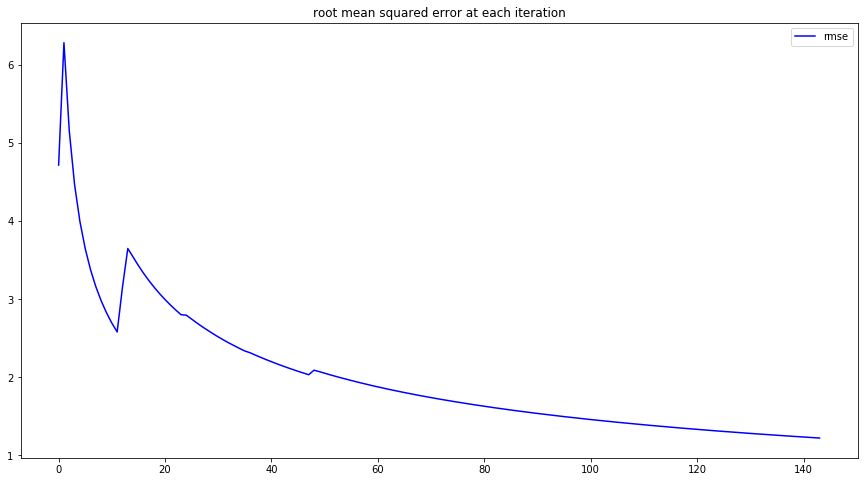

In [13]:
plt.figure(figsize=(15,8))
plt.title('root mean squared error at each iteration')
plt.plot(np.sqrt(mean_losses), color='b', label='rmse')
plt.legend()
plt.show()

In [14]:
split_point = round(len(series) * 0.75)
forecast = np.exp(pd.Series(predictions, index=series.index))[split_point:]
testing = series[split_point:]
print('MAPE: ', np.mean(np.abs((testing - forecast) / testing)))
print('RMSE: ', np.sqrt(np.mean((testing - forecast)**2)))

MAPE:  0.03891563350538472
RMSE:  22.15230722832612


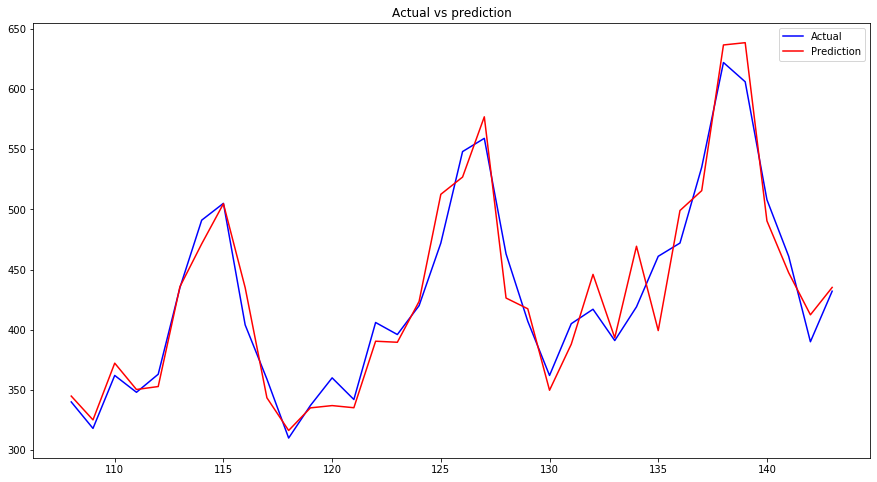

In [15]:
plt.figure(figsize=(15,8))
plt.title('Actual vs prediction')
plt.plot(testing, color='b', label='Actual')
plt.plot(forecast, color='r', label='Prediction')
plt.legend()
plt.show()